# Keen HACKATHON : AI for automatic process supervision, TU Dortmund

### Team Members :
* Sourabh Ranade(sourabhranade96@gmail.com)
* Prutha Modak (pruthamodak@gmail.com)
* Kavyashree Renukachari (kavyashree94v@gmail.com)
* Sayali Barve (sayalibarve.040@gmail.com)
* Kartik Kadur (karthikkr36@gmail.com)

The work done in this notebook is also available as a project in the gitlab repository :

[KEEN Hackathon](https://gitlab.com/keenchallenge1/keenchallenge.git)

#### Packages used in this notebook can be installed from the following cell.

In [1]:
# install necessary packages if not installed
!pip install tqdm
!pip install numpy
!pip install Pillow
!pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


#### Import necessary packages

In [1]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import logging

from torch.nn import init
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from random import shuffle
from torchvision import transforms, utils

### Set the proper device for execution
Set the proper device for moving the tensors and model while training/evaluation

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Index your labels

In [4]:
label = {"bad" : 0, "good" : 1}

### Dataloader
Below cell defines a dataloader for efficient loading of the dataset. In the training mode, the dataloader applies various data augmentation on the input image so that the model tries to generalize th data better.

In [5]:
class KeenDataloader():
    def __init__(self, root, 
                       labels = {"Fluten" : 0, "Normalzustand" : 1},
                       is_training=False,
                       transforms=None):
        self.transforms = transforms
        self.is_training = is_training
        self.images = self.get_paths(root)
        # indexed labels with key:vale pairs. Key being the parent folder containing the perticilar class images
        self.labels = labels
    
    def get_paths(self, root):
        img_format = ['.jpg', '.png']

        dirs = [x[0] for x in os.walk(root, followlinks=True) if not x[0].startswith('.')]
        datasets = []
        for fdir in dirs:
            for el in os.listdir(fdir):
                if os.path.isfile(os.path.join(fdir, el)) and \
                not el.startswith('.') and \
                any([el.endswith(ext) for ext in img_format]):
                    datasets.append(os.path.join(fdir,el))
        shuffle(datasets)
        return datasets

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        image = Image.open(image)
        if self.is_training:
            if self.transforms is None:
                self.transforms = transforms.Compose([
                                                    transforms.Resize((256, 256)),
                                                    transforms.RandomAffine([20,50]),
                                                    transforms.RandomRotation([30,70]),
                                                    transforms.RandomVerticalFlip(0.5),
                                                    transforms.RandomHorizontalFlip(0.5),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((0.5021, 0.4781, 0.4724), (0.3514, 0.3439, 0.3409)),
                                                      ])    
        else:
            self.transforms = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(),
                                                transforms.Normalize((0.5021, 0.4781, 0.4724), (0.3514, 0.3439, 0.3409)),])
        image = self.transforms(image)
        return {'image' : image, 'label' : torch.tensor(self.labels[os.path.basename(os.path.dirname(self.images[index]))], dtype=torch.int64)}  

### Dataset mean and standard deviation
Below function is used to calculate the mean and standard deviation of the dataset.

For this perticular task, the mean and standard deviation was computed to be:
Mean : (0.5021, 0.4781, 0.4724), Std : (0.3514, 0.3439, 0.3409), for (r,g,b) channels respectively. 

In [6]:
def get_mean_and_std(dataloader):
    channels_sum, channels_sum_squared, num_batches = 0, 0, 0
    for data in tqdm(dataloader):
        image = data['image']
        channels_sum += torch.mean(image, dim=[0,2,3])
        channels_sum_squared += torch.mean(image**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    std = (channels_sum_squared / num_batches - mean**2)**0.5
    logging.info(f"mean : {mean}, std : {std}")
    return mean, std

### Model
The below cell defines model architecture. The model takes as input the images of size which is a multiple of 64. (We are using a default input shape of 256x256 in our dataloader).

### Model Architecture
![Model Architecture](https://drive.google.com/uc?export=view&id=1T5tcZlk0ZZv5j5iinWiCSLDz01rcxGma)

In [2]:
from __future__ import division
from __future__ import print_function

import torch
import torch.nn as nn
from torch.nn import init
import os

class ConvBlock(nn.Module):
    def __init__(self,
                in_channels: int, 
                out_channels: int,
                kernel_size: int=3, 
                stride: int=1,
                padding=0,
                bias: bool = True) -> None:
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, inp):
        x = self.conv(inp)
        x = self.bn(x)
        return self.relu(x)

class KeenModel(nn.Module):
    def __init__(self, num_classes, input_shape, factor=4):
        super(KeenModel, self).__init__()

        input_channels = 3
        # initial convolution
        self.conv1 = ConvBlock(input_channels, 64//factor, stride=4, padding=1)
        self.conv2 = ConvBlock(64//factor, 128 // factor, stride=2, padding=1)
        self.conv3 = ConvBlock(128 // factor, 256 // factor, stride=2, padding=1)
        self.conv4 = ConvBlock(256 // factor, 512 // factor, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=2)
        self.fc1 = nn.Linear((512//factor) * (input_shape//64) * (input_shape//64), 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.relu = nn.ReLU(inplace=True)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                if m.bias is not None:
                    init.uniform_(m.bias)
                init.kaiming_uniform_(m.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def download_file_from_google_drive(id, destination):
    """
    Downloads file from drive
    """
    import requests
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = None
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            token = value
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:
                f.write(chunk)

def keen_model(pretrained=True, num_classes=2, input_shape=256, factor=4):
    """
    helper function to create model
    """
    try:
        model = KeenModel(num_classes, input_shape, factor)
        if pretrained:
            checkpoint_path = os.path.join(os.getcwd(), "checkpoint.pth")
            download_file_from_google_drive("1R06Oz4ZCcmHu3TGNG38raPfmVFYau2yy", checkpoint_path)
            checkpoint = torch.load(checkpoint_path, map_location='cpu')
            if 'state_dict' in checkpoint:
                model.load_state_dict(checkpoint['state_dict'], strict=False)
    except BaseException as e:
        print("Error downloading checkpoint. {e}")
        print("Please download it manually from the following url : https://drive.google.com/file/d/1R06Oz4ZCcmHu3TGNG38raPfmVFYau2yy/view?usp=sharing")
    return model

## Model Testing

### Test model using pretrained weights.
The pretrained weights for the model is available and unloaded under the google drive link :
[checkpoint](https://drive.google.com/file/d/1R06Oz4ZCcmHu3TGNG38raPfmVFYau2yy/view?usp=sharing)


To test the models performance using the pretrained weights, please use the function ```test_step(img_dir, ckpt_path)```,
defined in the cell below. The function ```test_step(img_dir, ckpt_path)``` accepts the path to the root directory of the test dataset.

If the checkpoint is available locally, pass its path as an argument to the ```ckpt_path``` parameter in ```test_step(img_dir, ckpt_path)``` function.

If this argument is ```None```, the function tries to download the checkpoint from the google drive link provided above.

In our validation process, our model acheved an Validation accuracy of 95 %. See the end of the notebook for plots showing training and validation accuracy.

In [8]:
test_config = {'batch_size': 16,
               'num_workers': 0,
               'pin_memory': True, 
               'drop_last': True}

def test_step(img_dir, ckpt_path=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if ckpt_path is not None:
        model = KeenModel(2, 256)
        # load checkpoint
        checkpoint = torch.load(ckpt_path, map_location='cpu')
        if 'state_dict' in checkpoint:
            model.load_state_dict(checkpoint['state_dict'], strict=False)
    else:
        model = keen_model(True)
    model = model.to(device)
    # create criterion
    criterion = nn.CrossEntropyLoss().to(device)
    # create testset
    testset = KeenDataloader(img_dir, labels=label, is_training=False)
    testloader = DataLoader(testset, **test_config)
    model.eval()
    test_loss = 0.0
    iteration = 0
    correct = 0
    total = 0
    for data in tqdm(testloader):
        iteration+=1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'].to(device), data['label'].to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels)
        total += labels.size(0)
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()

        test_loss += loss.item()
    print('[%5d] Test loss: %.3f, Test Accuracy: %.3f' %
                    (iteration, test_loss/(iteration+1e-5), correct/(total+1e-5)))
    logging.info(f'Test completed')
    return test_loss/(iteration+1e-5), correct/(total+1e-5)

In [9]:
loss, acc = test_step("data/ValidationData")
print(loss, acc)

100%|██████████| 198/198 [04:22<00:00,  1.33s/it]

[  198] Test loss: 0.101, Test Accuracy: 0.958
0.1012925382737863 0.9577020171789709


### Predict on a single image
There is a possibility to predict on a single image sample using the ```predict(image_path, ckpt_path)``` function. Just pass the path of the image as an argument and the function returns the predicted label.

The loader and index are mapped as follows:
* 0 : Fluten
* 1 : Normalzustand

Again pass the locally downloaded checkpoint path to the ```ckpt_path``` argument to use locally available checkpoint.

If this argument is ```None```, the function tries to download the checkpoint from the google drive link provided above.

In [10]:
def predict(image_path, ckpt_path=None):
    label = {0 : "Fluten", 1: "Normalzustand"}
    # create model
    if ckpt_path is not None:
        model = KeenModel(2, 256)
        # load checkpoint
        checkpoint = torch.load(ckpt_path, map_location='cpu')
        if 'state_dict' in checkpoint:
            model.load_state_dict(checkpoint['state_dict'], strict=False)
    else:
        model = keen_model(True)
    # basic transformations
    transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(),
                                    transforms.Normalize((0.5021, 0.4781, 0.4724), (0.3514, 0.3439, 0.3409))])
    # open image
    image = Image.open(image_path)
    image = transform(image)
    image = torch.unsqueeze(image, dim=0)
    model = model.eval() 
    outputs = model(image)
    _, prediction = torch.max(outputs, dim=1)
    probablities = torch.nn.functional.softmax(outputs.squeeze(), dim=0)
    print(f"Fluten : {probablities[0]*100} %, Normalzustand : {probablities[1]*100} %")
    return label[int(prediction)]

In [11]:
predict("data/ValidationData/bad/fluten005339.png")

Fluten : 100.0 %, Normalzustand : 2.2069306104821607e-10 %


'Fluten'

## Model Training

### Run Configurations
The following block contains the run configurations that can be set while training the model. 

We have trained the model with the configurations shown below:

* 'train_path' : "path/to/dataroot/Training",
*  'val_path' : "path/to/dataroot/Validation",
*    'epochs' : 50,
*    'lr' : 0.0001,
*    'wd' : 0,
*    'batch_size' : 16,
*    'val_batch_size' : 16,
*    'num_workers' : 0,
*    'save_root' : "path/to/savedirectory",
*    'checkpoint' : "path/to/savedirectory/checkpoint",
*    'logs_root' : "path/to/savedirectory/logs",
*    'resume' : "path/to/checkpoint",
*    'print_freq' : 200,
*    'save_freq' : 5,
*    'val_freq' : 5,
*    'initial_eval' : False,
*    'is_training' : True

Please cheange the values according to your requirements. If checkpoint path is None, the the model is initialized with random initialization.

In [12]:
config = {
    'train_path' : "data/Training",
    'val_path' : "data/Validation",
    'epochs' : 20,
    'lr' : 0.0001,
    'wd' : 0.0001,
    'batch_size' : 64,
    'val_batch_size' : 64,
    'num_workers' : 0,
    'save_root' : "path/to/save/root",
    'checkpoint' : "path/to/save/root/checkpoint",
    'logs_root' : "path/to/save/root/logs",
    'resume' : "path/to/checkpoint",
    'print_freq' : 100,
    'save_freq' : 1,
    'val_freq' : 2,
    'initial_eval' : False,
    'is_training' : True,
    'lr_factor' : 0.1,
    'lr_step_size' : 7,
    'start_epoch' : 0,
}

### Functions required for training
The below cells contain the functions required for training the model

### Functions to create dataloaders and model

In [13]:
def create_dataloader(config):
    train_set = KeenDataloader(config['train_path'], is_training=True)
    val_set = KeenDataloader(config['val_path'], is_training=False)
    tkwargs = {'batch_size': config['batch_size'],
               'num_workers': config['num_workers'],
               'pin_memory': True, 'drop_last': True}
    trainloader = DataLoader(train_set, **tkwargs)
    tkwargs = {'batch_size': config['val_batch_size'],
               'num_workers': config['num_workers'],
               'pin_memory': True, 'drop_last': True}
    valloader = DataLoader(val_set, **tkwargs)
    return trainloader, valloader

def create_model_and_optimizer():
    model = KeenModel(2, 256).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['wd'])

    return model, criterion, optimizer

### Functions to load pretrained weights

In [14]:

def load_model(model, optimizer, config):
    if config["resume"] is not None : 
        checkpoint = torch.load(config['resume'], map_location='cpu')
        if 'state_dict' in checkpoint:
            model.load_state_dict(checkpoint['state_dict'], strict=False)
        if 'optimizer' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])

### Functions to perform train step and val step

In [10]:
def train_step(model, criterion, optimizer, trainloader, epoch):
    running_loss = 0.0
    iteration = 0
    correct = 0
    total = 0
    for data in tqdm(trainloader):
        iteration+=1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'].to(device), data['label'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # calculate acc
        total += labels.size(0)
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()

        # print statistics
        running_loss += loss.item()
        if iteration % config['print_freq'] == 0:
            logging.info('[%d, %5d] loss: %.3f, accuracy: %.3f' %
                (epoch + 1, iteration, running_loss/(iteration+1e-5), correct/(total+1e-5)))
    logging.info('[%d, %5d] Epoch loss: %.3f, Accuracy: %.3f' %
                    (epoch + 1, iteration, running_loss/(iteration+1e-5), correct/(total+1e-5)))
    logging.info(f'Epoch {epoch} completed')
    return running_loss/(iteration+1e-5), correct/(total+1e-5)

def val_step(model, criterion, valloader):
    model.eval()
    val_loss = 0.0
    iteration = 0
    correct = 0
    total = 0
    for data in tqdm(valloader):
        iteration+=1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'].to(device), data['label'].to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels)
        total += labels.size(0)
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        val_loss += loss.item()
    logging.info('[%5d] Validation loss: %.3f, Validation Accuracy: %.3f' %
                    (iteration, val_loss/(iteration+1e-5), correct/(total+1e-5)))
    logging.info(f'Validation completed')
    return val_loss/(iteration+1e-5), correct/(total+1e-5)

### Function to run train epoch

In [ ]:
def train(epochs, model, criterion, optimizer, trainloader, valloader):
    metrics = {'train_loss' : [], 'train_acc' : [], 'val_loss' : [], 'val_acc' : []}
    model.train()
    # le scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, config['lr_step_size'])
    for epoch in range(config['start_epoch'], epochs):
        logging.info(f"Current learning rate : {scheduler.get_last_lr()}")
        # train a single epoch
        train_loss, train_acc = train_step(model, criterion, optimizer, trainloader, epoch)
        # validation
        if epoch % config['val_freq'] == 0:
            val_loss, val_accuracy = val_step(model, criterion, valloader)
            metrics['val_loss'].append(val_loss)
            metrics['val_acc'].append(val_accuracy)
        # lr schedule
        scheduler.step()
        # update metrics
        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)
        # save model
        if epoch % config['save_freq'] == 0:
            save_model(model, optimizer, epoch, config)
            logging.info(f"Model saved under : {os.path.join(config['save_root'], f'ckpt_epoch_{epoch}.pth')}")
    # save at the end of epoch
    save_model(model, optimizer, epoch, config)
    logging.info(f"Model saved under : {os.path.join(config['save_root'], f'ckpt_epoch_{epoch}.pth')}")
    return metrics

def save_model(model, optimizer, epoch, config):
    # save checkpoint
    model_optim_state = {'epoch': epoch,
                         'state_dict': model.state_dict(),
                         'optimizer': optimizer.state_dict(),
                         }
    model_name = os.path.join(
        config['checkpoint'], 'ckpt_epoch_%03d_.pth' % (
            epoch))
    torch.save(model_optim_state, model_name)
    logging.info('saved model {}'.format(model_name))

## Steps to train the model
Run the below cell to train the model.

In [ ]:
os.makedirs(config['save_root'], exist_ok=True)
os.makedirs(config['logs_root'], exist_ok=True)
os.makedirs(config['checkpoint'], exist_ok=True)

logging.basicConfig(level=logging.INFO,
                filename=os.path.join(config['logs_root'], 'stdout.log'),
                format='%(asctime)s %(message)s')
logging.info('Run configurations:')
for item in config:
    logging.info(f"{item} : {config[item]}")
logging.info("Creating dataloaders")
trainloader, valloader = create_dataloader(config)
logging.info("Creating model, optimizer and criterion functions")
model, criterion, optimizer = create_model_and_optimizer()

if config["initial_eval"]:
    val_loss = val_step(model, criterion, valloader)
logging.info(f"Training model on {device}:")
metrics = train(config['epochs'], model, criterion, optimizer, trainloader, valloader)
with open(os.path.join(config['save_root'], 'metrics.pkl'), 'wb') as pkl:
    pickle.dump(metrics, pkl, pickle.HIGHEST_PROTOCOL)
logging.info('Finished Training')

### Metrics on training.
We have trained the model with the following main parameters:
* Epochs : 20
* Learning rate : 0.0001
* Weight decay : 0.0001
* Batch Size : 64
* Loss : Cross Entropy
* Optimizer : Adam

The below graphs plots the accuracy and loss plots from the training and validation that was run.

The values of accuracy and loss is stored as a python pickled file in the following link : 
[Metrics Pickled file](https://drive.google.com/file/d/1bfeE9c6u8Q299BFVuawrs5Xd8Ioa8wQu/view?usp=sharing)

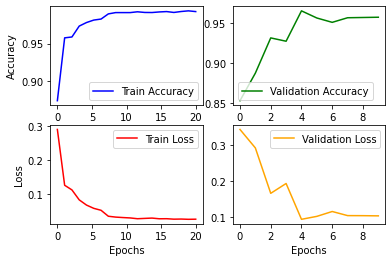

In [3]:
import pickle
import matplotlib.pyplot as plt

metrics_path = os.path.join(os.getcwd(), "metrics1.pkl")
download_file_from_google_drive("1bfeE9c6u8Q299BFVuawrs5Xd8Ioa8wQu", metrics_path)
with open(metrics_path, 'rb') as metrics_file:
    metrics = pickle.load(metrics_file)
    # plot the graphs
    fig, axs = plt.subplots(2, 2)
    # plot train acc and train loss
    epochs = np.linspace(0, 20, 20)
    axs[0,0].plot(epochs, metrics['train_acc'],color = 'blue', label="Train Accuracy")
    axs[0,0].set(ylabel='Accuracy')
    axs[0, 0].legend()
    axs[1,0].plot(epochs, metrics['train_loss'],color = 'red', label="Train Loss")
    axs[1,0].set(ylabel='Loss')
    axs[1, 0].legend()
    axs[0,1].plot(range(0,10,1), metrics['val_acc'], color = 'green', label="Validation Accuracy")
    axs[1,0].set(xlabel='Epochs')
    axs[0, 1].legend()
    axs[1,1].plot(range(0,10,1), metrics['val_loss'], color = 'orange', label="Validation Loss")
    axs[1,1].set(xlabel='Epochs')
    axs[1, 1].legend()
    fig.savefig('plot.png')
    fig.show()
    